# Visualization in python
There are several [visualization](https://en.wikipedia.org/wiki/Edge_detection) tools for 3D imagery have been developed with/for Python, for example
Matplotlib (Hunter, 2007), Mayavi (Ramachandran & Varoquaux, 2011), the [ipyvolume](https://github.com/maartenbreddels/ipyvolume/), the yt Project
(Turk et al., 2010), and the Visualization Toolkit (VTK) (Schroeder, Lorensen, & Martin, 2006). 

The 3 main challenges of available tools are: 
a. working with large volumes: image sizes
b. complexity of APIs: how many lines for simple rendering
c. compatibility to ipynb: mostly crash

VTK is a powerful scientific visualization library with Python bindings, and speedy C++ backend. The library [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets) provides interactive ipywidgets to visualize images in 2D and 3D 





In [7]:
import numpy as np
import matplotlib.pyplot as plt

#from ipywidgets import interact

#from scipy import ndimage as ndi

from skimage import exposure, io, measure
                   # morphology, restoration, segmentation, transform,
                    #util)

%matplotlib inline

Let's read the original image and the labeled result from previous lesson:

In [8]:
input_filename="images/cells.tif"
orig = io.imread(input_filename)
equalized = exposure.equalize_hist(orig)

In [9]:
from skimage.external import tifffile
inputfile = 'images/cells_interior_labels.tiff'
relabeled = tifffile.imread(inputfile)

Let's create a simple visualizer

In [34]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

def slicer(z):
    plt.imshow(relabeled[z,:,:], cmap='gray')

interact(slicer, z=widgets.IntSlider(min=0,max=60,step=1,value=5));

interactive(children=(IntSlider(value=5, description='z', max=60), Output()), _dom_classes=('widget-interact',…

## Surface of 3D objects
`skimage.measure.regionprops` **==>** `skimage.measure.marching_cubes` **==>** `skimage.measure.mesh_surface_area`

Perimeter measurements are not computed for 3D objects. The 3D extension of perimeter is surface area. We can measure the surface of an object by generating a surface mesh with 
- `skimage.measure.marching_cubes`returns 2 arrays: spatial coordinates for V unique mesh vertices and F faces that define triangular faces via referencing vertex indices from V. This algorithm specifically outputs triangles, so each face has exactly three indices.

In [ ]:
selected_cell = 3

regionprops = measure.regionprops(relabeled.astype('int'))
# skimage.measure.marching_cubes expects ordering (row, col, pln)
volume = (relabeled == regionprops[selected_cell].label).transpose(1, 2, 0)

verts_px, faces_px, _, _ = measure.marching_cubes_lewiner(volume, level=0, spacing=(1.0, 1.0, 1.0))

Now we will compute the surface area of the mesh with `skimage.measure.mesh_surface_area`.

In [ ]:
surface_area_pixels = measure.mesh_surface_area(verts_px, faces_px)
print("Surface area (total pixels): {:0.2f}".format(surface_area_pixels))

Remember that the cell data comes from an anisotropic acquisition, then we need to customize spacing:

In [ ]:
# The microscope reports the following spacing:
original_spacing = np.array([0.2900000, 0.0650000, 0.0650000])
print(f'* Microscope original spacing: {original_spacing}')

# We downsampled each slice 4x to make the data smaller
rescaled_spacing = original_spacing * [1, 4, 4]
print(f'* Microscope after rescaling images: {rescaled_spacing}')

# Normalize the spacing so that pixels are a distance of 1 apart
spacing = rescaled_spacing / rescaled_spacing[2]
print(f'* Microscope normalized spacing: {spacing}')

In [ ]:
verts, faces, _, _ = measure.marching_cubes_lewiner(volume, level=0, spacing=tuple(spacing))
surface_area_actual = measure.mesh_surface_area(verts, faces)

print("Surface area (total pixels): {:0.2f}".format(surface_area_pixels))
print("Surface area (actual): {:0.2f}".format(surface_area_actual))

In [ ]:
plt.plot(verts[:,0],verts[:,1],'b.')

# MPL_toolkit:
It ships with Matplotlib and thus may be a lighter weight solution for some use cases. Provide basic 3D plotting of: 
- scatter, 
- surf, 
- line, 
- mesh

Not the fastest or most feature complete 3D library out there. Check out the mplot3d [tutorial](https://matplotlib.org/tutorials/toolkits/mplot3d.html#sphx-glr-tutorials-toolkits-mplot3d-py) for more information. mplot3d supplies an axes object that can create a 2D projection of a 3D scene.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
#method for creating a 3D axes object
ax = fig.gca(projection='3d')

ax.scatter(verts[:,0],verts[:,1],verts[:,2])

plt.show()


## Exercise 1:
a) Select a different cell and calculate the actual surface area

b) explore parameters to improve the scatter plot, e.g., label and colors

c) find the largest connected component

In [ ]:
%load solution02_01_a.py

In [ ]:
%load solution02_01_b.py

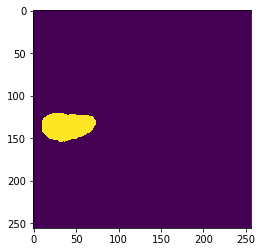

In [19]:
%load solution02_01_c.py

Is it possible to create a better projection that that? Yes, the volume (polyhedron) can be visualized using the mesh, a set of polygons determined by the vertexes and faces.

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=(10, 10))

#method for creating a 3D axes object
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(verts_px[faces_px])
ax.add_collection3d(mesh)

#retrieve spatial coord of selected cell
min_pln, min_row, min_col, max_pln, max_row, max_col = regionprops[selected_cell].bbox

#requires setting the region of interest
ax.set_xlim(min_row, max_row)
ax.set_ylim(min_col, max_col)
ax.set_zlim(min_pln, max_pln)
plt.show()

The command `mesh.set_edgecolor('black')` makes edges visible

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(verts_px[faces_px])
mesh.set_edgecolor('black')
ax.add_collection3d(mesh)

#retrieve spatial coord of selected cell
min_pln, min_row, min_col, max_pln, max_row, max_col = regionprops[selected_cell].bbox

#requires setting the region of interest
ax.set_xlim(min_row, max_row)
ax.set_ylim(min_col, max_col)
ax.set_zlim(min_pln, max_pln)

#layout improvements
ax.set_xlabel('col')
ax.set_ylabel('row')
ax.set_zlabel('pln')

plt.tight_layout()
plt.show()

# ITK and ITKwidgets in itkwidgets
- def: 

In [ ]:
#Dani TODO: discuss package 
#https://itkpythonpackage.readthedocs.io/en/latest/Quick_start_guide.html
#https://itk.org/ITKExamples/src/index.html

#https://github.com/InsightSoftwareConsortium/itkwidgets

In [ ]:
import itk
from itkwidgets import view

In [ ]:
import itk

image = itk.imread(input_filename)
median = itk.MedianImageFilter.New(image, Radius = 2)
#itk.imwrite(median, output_filename)

In [ ]:
plt.imshow(median[20],cmap='inferno')

In [ ]:
print(f"* Data shape: {relabeled.shape}")
print(f"* Data type:  {relabeled.dtype}")
print(f"* Data range: ({relabeled.min()}, {relabeled.max()})")

In [ ]:
#Reformat the numpy array into an itk matrix
image = itk.GetImageFromArray(relabeled.astype(np.int16))
view(image, slicing_planes=True)

#showing full stack

In [ ]:
image2 = itk.imread('images/cells_interior_labels.tiff') #,itk.ctype('float')) #add this param if needed
viewer = view(image2,slicing_planes=True)


In [ ]:
import ipywebrtc as webrtc
recorder = webrtc.VideoRecorder(stream=viewer, filename='widget_video.webm', autosave=True)
recorder

# Exercise 3. 
Read the file at images/cells_interior_labels.tiff using skimage, then convert the file to visualize with itkwidgets